In [2]:
import requests
import pandas as pd
import numpy as np
from io import StringIO
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
#from google.colab import output
#Import all necessary packages 

In [3]:
'''
SUMMARY: 
code block to create a loop that combines the index files from 2017 through 2022. 
Then merge the combined index file with the list of S&P 500 firms given as part of Case 1, 
keeping only cases that show up in both datasets. 
Finally, mask the resulting DataFrame to return only 10-K, 10-Q, and 8-K filings.
'''

#set an email and username to give SEC EDGAR for requests
dl_user_email = 'beavztx@gmail.com' 
dl_user_name = 'No Company (personal research)' 

#instantiate the master data frame which will be populated with filings
master_df = pd.DataFrame()

#loop through the desired range of years
for yr in range(2017, 2022):
  #loop through each quarter of each year
  for qtr in range(1,5):    
     #create the url for each year, quarter
     url = f"https://www.sec.gov/Archives/edgar/full-index/{yr}/QTR{qtr}/company.idx"
     idx_content = requests.get(url, headers={'User-Agent': f'{dl_user_name} {dl_user_email}'}).content
     temp_df = pd.read_fwf(StringIO(idx_content.decode('ISO-8859-1')), skiprows=(0,1,2,3,4,5,6,7,9), widths = [62,12,12,12,52])
     #concatenate the master and temporary dataframes 
     master_df = pd.concat([master_df, temp_df])    

#merge on the given list of S&P 500 CIDS
sp500 = pd.read_csv('https://tinyurl.com/sp500ciks')
sp500_fs_data = pd.merge(left = sp500, 
                         right = master_df,  
                         left_on = 'cik',
                         right_on = 'CIK',
                         how = 'inner')

#Mask the resultant DataFrame to only 10-K, 10-Q, 8-K filings 
my_func_ret_df = sp500_fs_data.loc[(sp500_fs_data['Form Type'] == "10-K") | (sp500_fs_data['Form Type'] == "10-Q") | (sp500_fs_data['Form Type'] == "8-K"),:].copy()
my_func_ret_df

,company name,cik,Company Name,Form Type,CIK,Date Filed,File Name
0,AMERICAN AIRLINES GROUP INC,6201,American Airlines Group Inc.,10-K,6201,2017-02-22,edgar/data/6201/0001193125-17-051216.txt
8,AMERICAN AIRLINES GROUP INC,6201,American Airlines Group Inc.,8-K,6201,2017-01-11,edgar/data/6201/0001193125-17-007435.txt
9,AMERICAN AIRLINES GROUP INC,6201,American Airlines Group Inc.,8-K,6201,2017-01-27,edgar/data/6201/0001193125-17-020515.txt
10,AMERICAN AIRLINES GROUP INC,6201,American Airlines Group Inc.,8-K,6201,2017-01-30,edgar/data/6201/0001193125-17-023738.txt
11,AMERICAN AIRLINES GROUP INC,6201,American Airlines Group Inc.,8-K,6201,2017-02-09,edgar/data/6201/0001193125-17-035393.txt
...,...,...,...,...,...,...,...
504286,ORGANON & CO,1821825,Organon & Co.,8-K,1821825,2021-06-29,edgar/data/1821825/0001104659-21-086583.txt
504293,ORGANON & CO,1821825,Organon & Co.,10-Q,1821825,2021-08-16,edgar/data/1821825/0001821825-21-000009.txt
504309,ORGANON & CO,1821825,Organon & Co.,8-K,1821825,2021-08-12,edgar/data/1821825/0001104659-21-103773.txt
504311,ORGANON & CO,1821825,Organon & Co.,10-Q,1821825,2021-11-12,edgar/data/1821825/0001628280-21-023199.txt


In [4]:
'''
SUMMARY: 
Create a copy of the master dataframe of filings, then manipulate the copy, adding the full URL to the file name column. 
Next, apply the context search modified method to run the function for each file. 

'''

#create a copy of the  df
master_index_copy = my_func_ret_df.copy()
#complete URLS
master_index_copy['File Name'] = 'https://www.sec.gov/Archives/' + master_index_copy['File Name']

#write a modified version of the context search function to pull the context around a search term
def context_search(url, search_phrase, context_distance):
    search_start = 0
    context_list = []
    #request the content of the filing from EDGAR using the defined user name and email
    text = str(requests.get(url, headers={'User-Agent': f'{dl_user_name} {dl_user_email}'}).content).lower() 

    #for each instance of the defined search_phrase, return the text within context_distance and add it as an element to context_list
    for occurance in range(text.count(search_phrase)):
        location = text.find(search_phrase, search_start)
        context_string = text[location-context_distance:location+context_distance]
        search_start = location + 1
        context_list.append([context_string])
    
    #if context_list has any content, then return to context list. Otherwise return a null value
    if len(context_list) > 0:
        return context_list
    else:
        return np.nan

#draw a random sample of filings from the index
rsample = master_index_copy.sample(100).reset_index(drop = True)

#loop over items in the DF and apply the function to each URL
for row in range(len(rsample)):
    rsample.loc[row,"gw_context"] = context_search(rsample.loc[row,'File Name'], "goodwill", 500)
   
    if type(rsample.loc[row,"gw_context"]) == list:
        rsample.loc[row,"gw_count"] = len(rsample.loc[row,"gw_context"])
    else:
        rsample.loc[row,"gw_count"] = 0

In [5]:
# Use groupby to see how often companies mention goodwill in different types of filings
rsample[['Form Type', 'gw_count']].groupby('Form Type').aggregate(["mean","count", "sum"])

gw_count              
                 mean count     sum
Form Type                          
10-K       925.333333     3  2776.0
10-Q       371.928571    14  5207.0
8-K         15.337349    83  1273.0

In [6]:
# loop through each row in rsample and extract the Standard Industrial Classification
for row in range(len(rsample)):
    # for debugging, print the row # and URL
    #print(row, rsample.loc[row,'File Name']) 

    # Access the current row File name Url and Extract all text
    item = requests.get(rsample.loc[row,'File Name'], headers={'User-Agent': f'{dl_user_name} {dl_user_email}'}).text

    # Find "CLASSIFICATION" and store the location
    classification_location = item.find("CLASSIFICATION",0)

    # Extract the context surrounding "CLASSIFICATION"
    class_text = str(item[classification_location:classification_location+200])
    
    # Find the start of the Industry based on length of search text
    class_start = class_text.find("\\t") + len("CLASSIFICATION:\t\t")

    # Find the end of the Industry based on the location of the "]" that follows each ID
    class_end = class_text.find("]",0) + 1

    # Extract only the Industry from the located text
    industry = class_text[class_start:class_end]

    #Store the extracted industry name back into rsample
    rsample.loc[row,'Industry'] = industry

# Print rsample to verify
rsample

,company name,cik,Company Name,Form Type,CIK,Date Filed,File Name,gw_context,gw_count,Industry
0,DANAHER CORP,313616,DANAHER CORP /DE/,8-K,313616,2018-07-19,https://www.sec.gov/Archives/edgar/data/313616...,[rate the businesses we acquire and achieve th...,1.0,"INDUSTRIAL INSTRUMENTS FOR MEASUREMENT, DISPLA..."
1,FORD MOTOR CO,37996,FORD MOTOR CO,8-K,37996,2018-10-02,https://www.sec.gov/Archives/edgar/data/37996/...,NaN,0.0,MOTOR VEHICLES & PASSENGER CAR BODIES [3711]
2,DUKE REALTY CORP,783280,DUKE REALTY CORP,8-K,783280,2021-04-30,https://www.sec.gov/Archives/edgar/data/783280...,NaN,0.0,REAL ESTATE INVESTMENT TRUSTS [6798]
3,LINCOLN NATIONAL CORP,59558,LINCOLN NATIONAL CORP,8-K,59558,2017-08-02,https://www.sec.gov/Archives/edgar/data/59558/...,"[#000000;font-size:10pt;"">&#xfeff;</font>\n\t\...",18.0,LIFE INSURANCE [6311]
4,JACOBS SOLUTIONS INC,52988,JACOBS ENGINEERING GROUP INC /DE/,8-K,52988,2019-05-01,https://www.sec.gov/Archives/edgar/data/52988/...,NaN,0.0,HEAVY CONSTRUCTION OTHER THAN BUILDING CONST -...
...,...,...,...,...,...,...,...,...,...,...
95,JPMORGAN CHASE & CO,19617,JPMORGAN CHASE & CO,8-K,19617,2018-07-23,https://www.sec.gov/Archives/edgar/data/19617/...,NaN,0.0,NATIONAL COMMERCIAL BANKS [6021]
96,COGNIZANT TECH SOLUTIONS,1058290,COGNIZANT TECHNOLOGY SOLUTIONS CORP,8-K,1058290,2021-10-27,https://www.sec.gov/Archives/edgar/data/105829...,"[rtical-align:bottom""><font style=""color:#0000...",1.0,SERVICES-COMPUTER PROGRAMMING SERVICES [7371]
97,WEC ENERGY GROUP INC,783325,"WEC ENERGY GROUP, INC.",8-K,783325,2017-09-01,https://www.sec.gov/Archives/edgar/data/783325...,"[;&#10;territories; timing, resolution and imp...",1.0,ELECTRIC & OTHER SERVICES COMBINED [4931]
98,EVERSOURCE ENERGY,72741,EVERSOURCE ENERGY,8-K,72741,2019-02-20,https://www.sec.gov/Archives/edgar/data/72741/...,NaN,0.0,ELECTRIC SERVICES [4911]


In [7]:
#loop through every row in the rsample dataframe
for row in range(len(rsample)):
    #create a variable to store the count, setting to zero to start
    context_count = 0
    #only search those rows with at least 1 occurance of goodwill
    if rsample.loc[row,"gw_count"] > 0:
        #now loop through each item in the context list for each row
        for context in range(len(rsample.loc[row,"gw_context"])):
                context_count += 1
            
    rsample.loc[row,'context_count'] = context_count

In [9]:
#industry_Q = rsample[['Industry','context_count']].groupby('Industry').aggregate(["mean","count", "sum"]).dropna()
industry_Q = rsample[['Industry','context_count']].groupby('Industry').mean().dropna()

industry_Q

,context_count
Industry,
ABRASIVE ASBESTOS & MISC NONMETALLIC MINERAL PRODUCTS [3290],6.0
ACCIDENT & HEALTH INSURANCE [6321],0.0
AGRICULTURE PRODUCTION - CROPS [0100],0.0
APPAREL & OTHER FINISHED PRODS OF FABRICS & SIMILAR MATERIAL [2300],1.0
CABLE & OTHER PAY TELEVISION SERVICES [4841],44.0
...,...
TELEVISION BROADCASTING STATIONS [4833],68.0
TRANSPORTATION SERVICES [4700],10.0
WATER TRANSPORTATION [4400],1.0


In [10]:
industry_Q

,context_count
Industry,
ABRASIVE ASBESTOS & MISC NONMETALLIC MINERAL PRODUCTS [3290],6.0
ACCIDENT & HEALTH INSURANCE [6321],0.0
AGRICULTURE PRODUCTION - CROPS [0100],0.0
APPAREL & OTHER FINISHED PRODS OF FABRICS & SIMILAR MATERIAL [2300],1.0
CABLE & OTHER PAY TELEVISION SERVICES [4841],44.0
...,...
TELEVISION BROADCASTING STATIONS [4833],68.0
TRANSPORTATION SERVICES [4700],10.0
WATER TRANSPORTATION [4400],1.0


In [25]:
# resort industry_Q by the context_count in Descending order and show only the top 5
industry_Q_top5 = industry_Q.sort_values(by='context_count', ascending=False).head(5).reset_index()
industry_Q_top5

,Industry,context_count
0,"MEN'S & BOYS' FURNISHINGS, WORK CLOTHING, AND ...",1838.0
1,PHARMACEUTICAL PREPARATIONS [2834],1089.0
2,PERIODICALS: PUBLISHING OR PUBLISHING AND PRI...,883.0
3,TELEPHONE COMMUNICATIONS (NO RADIO TELEPHONE) ...,626.0
4,SERVICES-EDUCATIONAL SERVICES [8200],597.0


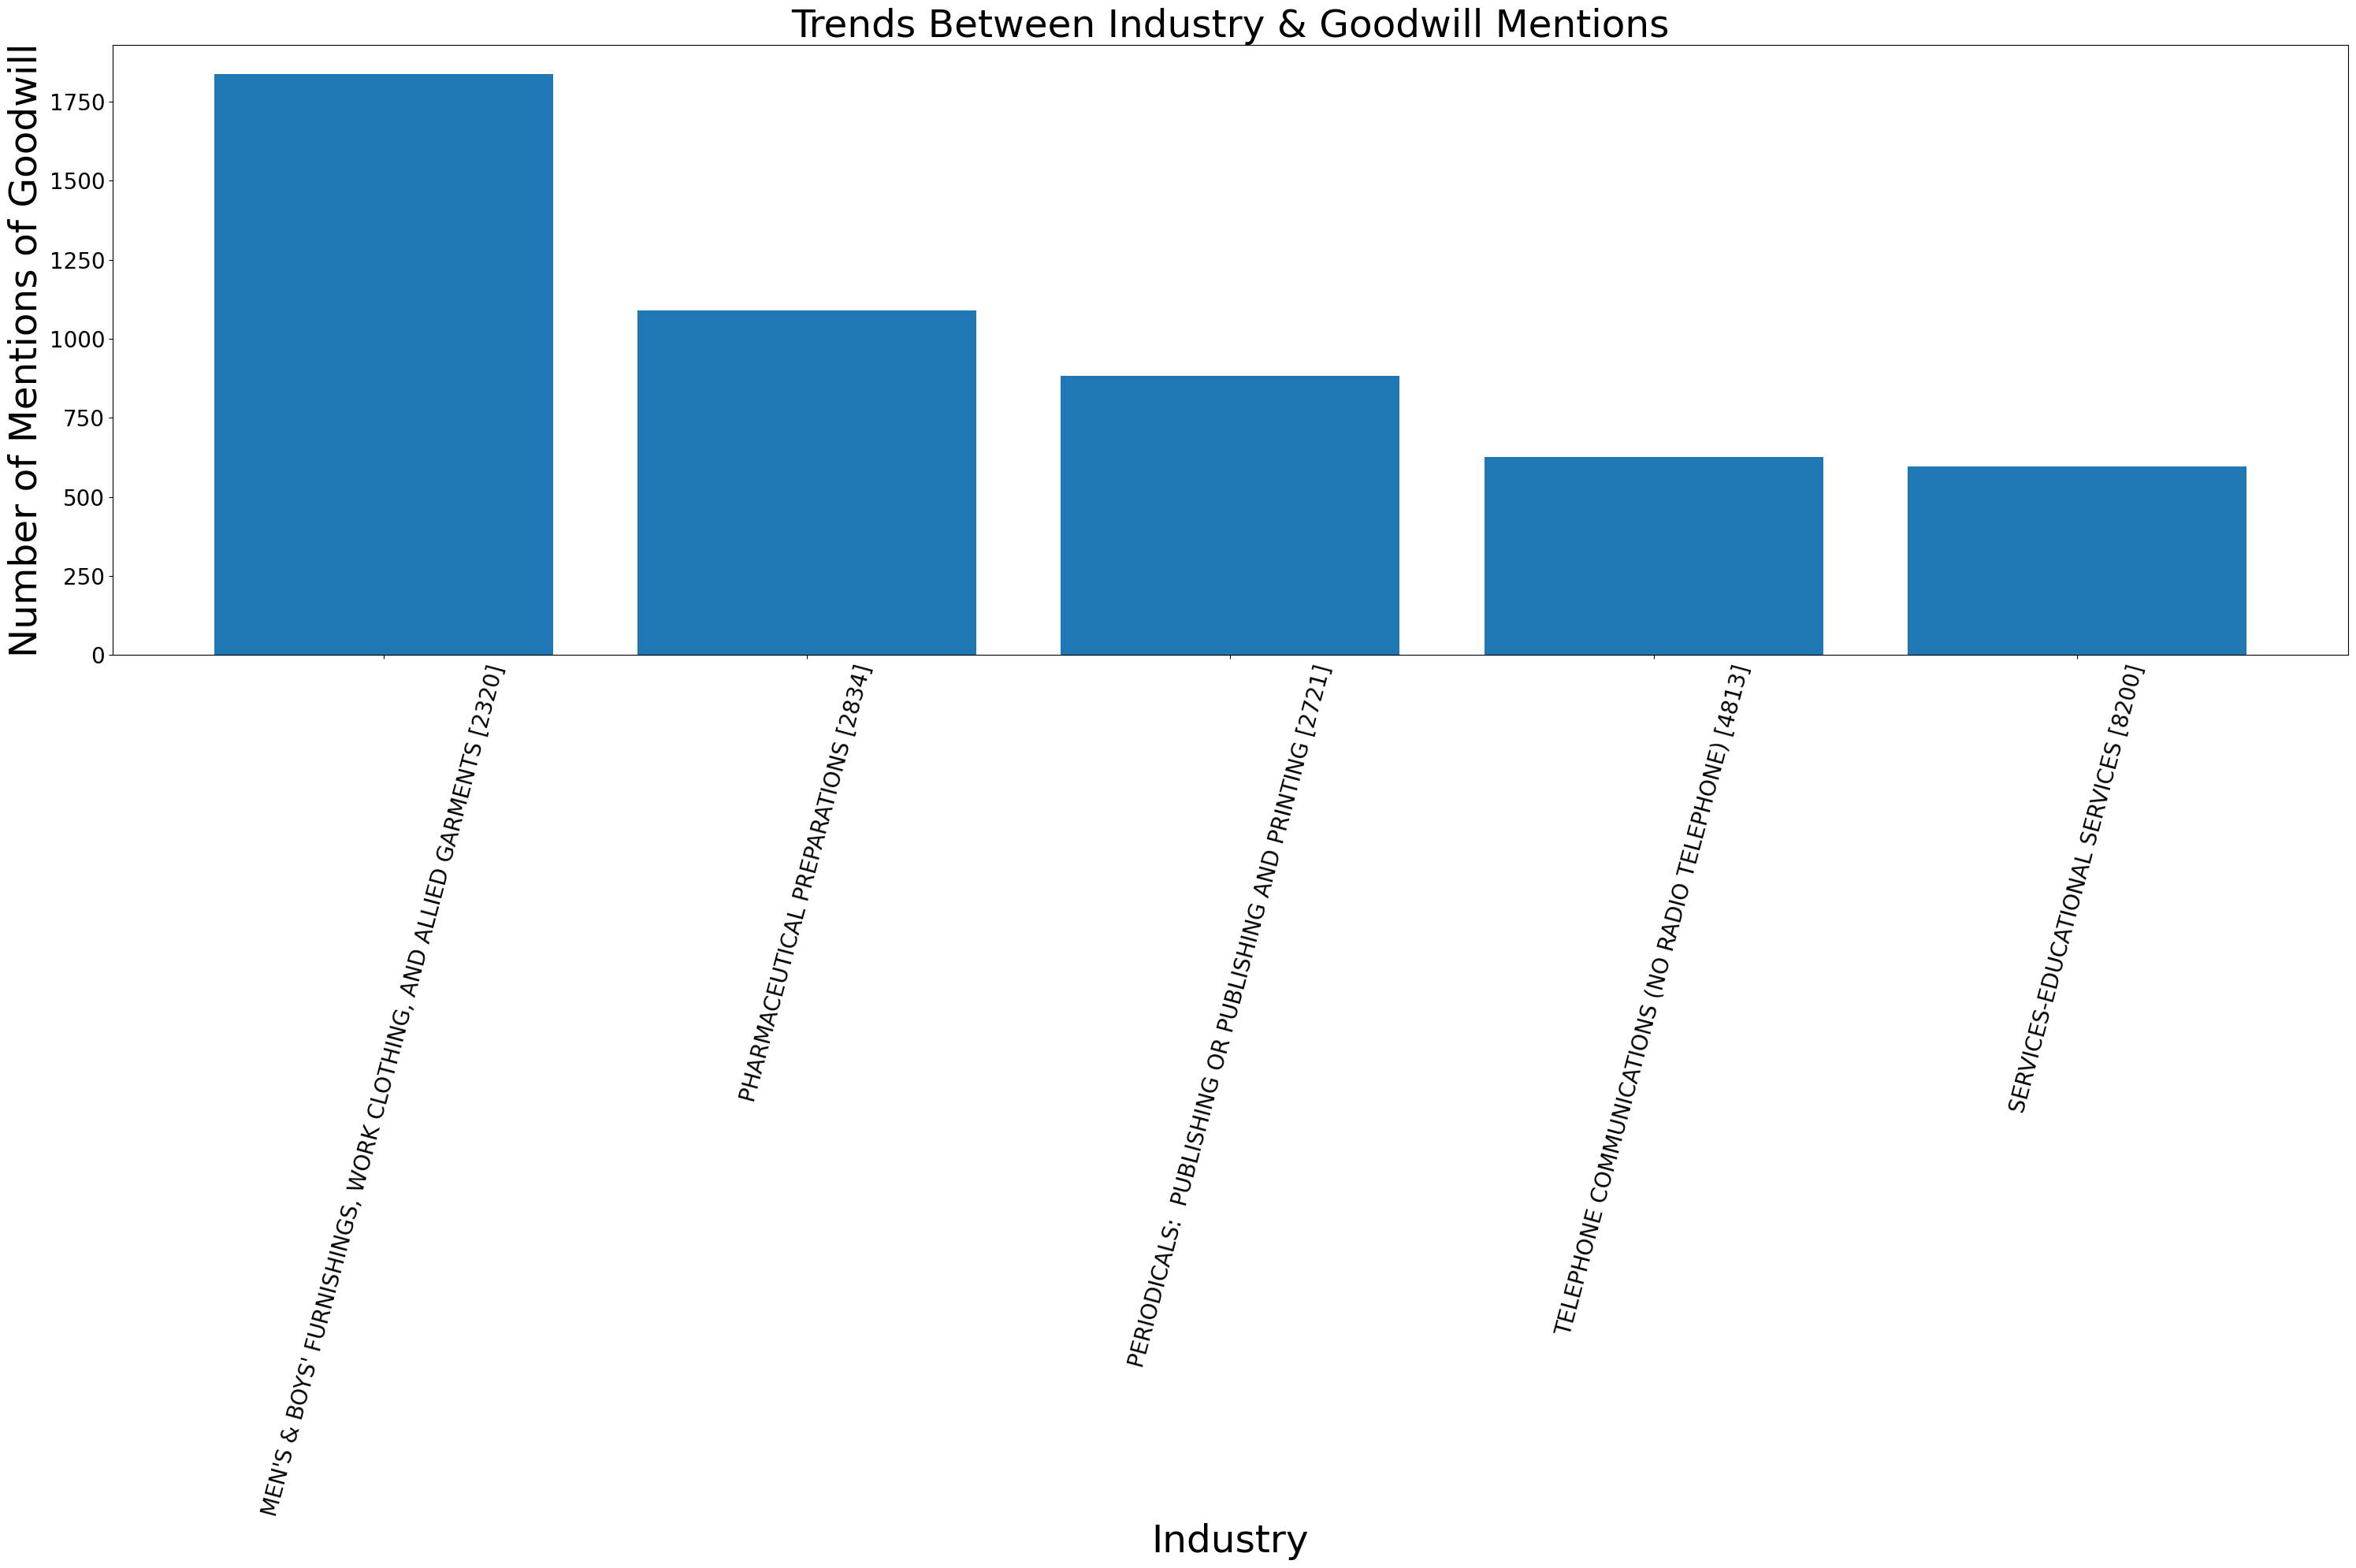

In [28]:
plt.figure(figsize=(30,20))
plt.bar(industry_Q_top5['Industry'], industry_Q_top5['context_count'])

plt.title('Trends Between Industry & Goodwill Mentions', size = 35)
plt.xlabel('Industry', size = 35)
plt.ylabel('Number of Mentions of Goodwill', size = 35)

plt.xticks(rotation = 75, fontsize = 20)
plt.yticks(fontsize = 20)

plt.style.use('ggplot')

plt.tight_layout()

plt.savefig('Trends_Between_Industry_and_GW_Mentions.png', dpi = 300)

plt.show()

In [11]:
plt.figure(figsize = (30, 20))

#plt.plot(industry_Q.loc['context_count'], label = 'count')
plt.bar("Misc. Health & Allied Services",industry_Q.loc['SERVICES-MISC HEALTH & ALLIED SERVICES, NEC [8090]','context_count'], color = 'pink')
plt.bar("Industrial Instruments",industry_Q.loc['INDUSTRIAL INSTRUMENTS FOR MEASUREMENT, DISPLAY, AND CONTROL [3823]','context_count'], color = 'deeppink')
plt.bar("Misc. Food Prep",industry_Q.loc['MISCELLANEOUS FOOD PREPARATIONS & KINDRED PRODUCTS [2090]','context_count'])
plt.bar("Heavy Construction (exc. buildings)",industry_Q.loc['HEAVY CONSTRUCTION OTHER THAN BUILDING CONST - CONTRACTORS [1600]','context_count'])
plt.bar("Air Cond. & Warm Air Heating Equip.",industry_Q.loc['AIR COND & WARM AIR HEATING EQUIP & COMM & INDL REFRIG EQUIP [3585]','context_count'])
plt.bar("Insurance - Fire, Marine, & Casualty",industry_Q.loc['FIRE, MARINE & CASUALTY INSURANCE [6331]','context_count'])
plt.bar("Measuring & Controlling Devices",industry_Q.loc['MEASURING & CONTROLLING DEVICES, NEC [3829]','context_count'])
#plt.bar("Retail - Department Stores",industry_Q.loc['RETAIL-DEPARTMENT STORES [5311]','context_count'])
#plt.bar("Pharmaceutical Prep.",industry_Q.loc['PHARMACEUTICAL PREPARATIONS [2834]','context_count'])
#plt.bar("Business Services",industry_Q.loc['SERVICES-BUSINESS SERVICES, NEC [7389]','context_count'])
#plt.bar("Electric Services",industry_Q.loc['ELECTRIC SERVICES [4911]','context_count'])
#plt.bar("Natural Gas Transmission & Distribution",industry_Q.loc['NATURAL GAS TRANSMISSION & DISTRIBUTION [4923]','context_count'])

plt.title('Trends Between Industry & Goodwill Mentions', size = 35)
plt.xlabel('Industry', size = 35)
plt.ylabel('Number of Mentions of Goodwill', size = 35)

plt.xticks(rotation = 75, fontsize = 20)
plt.yticks(fontsize = 20)

plt.style.use('ggplot')

plt.tight_layout()

plt.savefig('Trends_Between_Industry_and_GW_Mentions.png', dpi = 300)

plt.show()

KeyError: 'SERVICES-MISC HEALTH & ALLIED SERVICES, NEC [8090]'

<Figure size 3000x2000 with 0 Axes>